In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import seaborn as sns # visualization
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, KBinsDiscretizer
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.utils.np_utils import to_categorical

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Read train and test datasets and store the information in the appropriate dataframe variables
datadir = '/kaggle/input/titanic/'
data_train = pd.read_csv(os.path.join(datadir, 'train.csv'))
data_test = pd.read_csv(os.path.join(datadir, 'test.csv'))
print("Train dataset shape:", data_train.shape)
print("Test dataset shape:", data_test.shape)

data_train_test = [data_train, data_test]

data_train.head()

Train dataset shape: (891, 12)
Test dataset shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Age, Cabin and Embarked have null entries in the training set
data_train.info()
print('-'*50)

# Age, Cabin and Fare have null entries in the training set
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         41

In [4]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
data_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Connaghton, Mr. Michael",male,347082,B96 B98,S
freq,1,577,7,4,644


In [6]:
# Remove the cabin feature since it 77% of its training entries are null
# Also out of the 204 valid entries, 147 are unique and the alphanumeric code of the cabin
# does not directly correlate to the desired feature Survived
for data in data_train_test:
    data.drop(columns=['Cabin', 'Ticket'], inplace = True)

In [7]:
# Outputs the percentage of survivors for each gender
data_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [8]:
data_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [9]:
data_train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [10]:
data_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [11]:
data_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [12]:
for data in data_train_test:
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)
    data['Age'].fillna(data['Age'].median(), inplace = True)
    data['Fare'].fillna(data['Fare'].median(), inplace = True)
    
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 29.5+ KB


In [13]:
for data in data_train_test:
    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(data_train['Title'], data_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [14]:
for data in data_train_test:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    
data_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [15]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for data in data_train_test:
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)

data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [16]:
labelencoder = LabelEncoder()
#est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
for data in data_train_test:
    data['Embarked'] = labelencoder.fit_transform(data['Embarked'])
    data['Sex'] = labelencoder.fit_transform(data['Sex'])
    #data['Age'] = est.fit_transform(data['Age'])
    
    data.head

In [17]:
print(data_train['Embarked'].value_counts())
print(data_train['Sex'].value_counts())
data_train.head()

2    646
0    168
1     77
Name: Embarked, dtype: int64
1    577
0    314
Name: Sex, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,2,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,2,1


In [18]:
data_train['Embarked'].value_counts()

2    646
0    168
1     77
Name: Embarked, dtype: int64

In [19]:
data_train['FareBand'] = pd.qcut(data_train['Fare'], 3)
data_train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 8.662]",0.198052
1,"(8.662, 26.0]",0.402778
2,"(26.0, 512.329]",0.559322


In [20]:
for data in data_train_test:
    data.loc[ data['Fare'] <= 8.662, 'Fare'] = 3
    data.loc[(data['Fare'] > 8.662) & (data['Fare'] <= 26), 'Fare'] = 2
    data.loc[ data['Fare'] > 26, 'Fare'] = 1
    data['Fare'] = data['Fare'].astype(int)

data_train = data_train.drop(['FareBand'], axis=1)
data_train_test = [data_train, data_test]
    
data_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,3,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,1,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,3,2,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,1,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,3,2,1
5,6,0,3,"Moran, Mr. James",1,28.0,0,0,3,1,1
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,1,2,1
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,2,2,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,2,2,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,1,0,3


In [21]:
# New feature called SocialStatus = Fare * Pclass
for data in data_train_test:
    data['SocialStatus'] = data.Pclass * data.Fare

    #Discrete variables
    data['FamilySize'] = data ['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = 1 #initialize to yes/1 is alone
    data['IsAlone'].loc[data['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1
    
data_train.loc[:, ['SocialStatus', 'Pclass', 'Fare']].head(10)

,SocialStatus,Pclass,Fare
0,9,3,3
1,1,1,1
2,9,3,3
3,1,1,1
4,9,3,3
5,9,3,3
6,1,1,1
7,6,3,2
8,6,3,2
9,2,2,1


In [22]:
data_train[['SocialStatus', 'Survived']].groupby(['SocialStatus'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SocialStatus,Survived
0,1,0.656863
1,2,0.555556
3,4,0.460432
4,6,0.314815
5,9,0.212014
2,3,0.137931


In [23]:
data_train['AgeBand'] = pd.cut(data_train['Age'], 5)
data_train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.344168
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [24]:
for data in data_train_test:    
    data.loc[ data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age']
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,SocialStatus,FamilySize,IsAlone,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,3,2,1,9,2,0,"(16.336, 32.252]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,1,0,3,1,2,0,"(32.252, 48.168]"
2,3,1,3,"Heikkinen, Miss. Laina",0,1.0,0,0,3,2,2,9,1,1,"(16.336, 32.252]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,1,2,3,1,2,0,"(32.252, 48.168]"
4,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,3,2,1,9,1,1,"(32.252, 48.168]"


In [25]:
print(data_train['Title'].value_counts())

1    517
2    185
3    126
4     40
5     23
Name: Title, dtype: int64


In [26]:
data_train = data_train.drop(['AgeBand'], axis=1)
data_train_test = [data_train, data_test]
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,SocialStatus,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,3,2,1,9,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,1,0,3,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,1.0,0,0,3,2,2,9,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,1,2,3,1,2,0
4,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,3,2,1,9,1,1


In [27]:
def split_survived_died(data, feature):
    data_feature = data[feature]
    data_feature_survived = data_feature[data['Survived']==1]
    data_feature_died = data_feature[data['Survived']==0]
    return data_feature_survived, data_feature_died

In [28]:
def plot_survived_died(labels, data_survived, data_died):
    num_bins = len(labels)

    x = np.arange(num_bins)  # the label locations
    
    width = 0.2
    fig, ax = plt.subplots()

    hist, bins = np.histogram(data_survived, num_bins)
    hist2, bins = np.histogram(data_died, num_bins)

    rects1 = ax.bar(x - width/2, hist, width=width, color='green', label='Survived')
    rects2 = ax.bar(x + width/2, hist2, width=width, color='red', label='Died')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('People')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    return ax

Text(0.5, 0, 'Port of Embarkation')

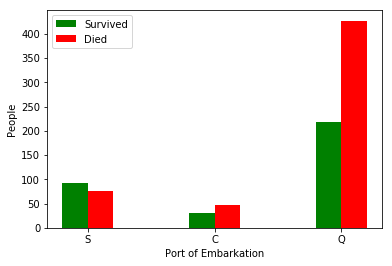

In [29]:
data_embarked_survived, data_embarked_died = split_survived_died(data_train, 'Embarked')

labels = ['S', 'C', 'Q']
ax = plot_survived_died(labels, data_embarked_survived, data_embarked_died)
ax.set_xlabel('Port of Embarkation')

Text(0.5, 0, 'Sex')

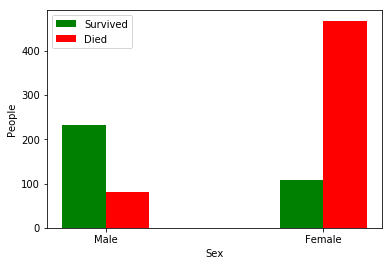

In [30]:
data_sex_survived, data_sex_died = split_survived_died(data_train, 'Sex')

labels = ['Male', 'Female']
ax = plot_survived_died(labels, data_sex_survived, data_sex_died)
ax.set_xlabel('Sex')

In [31]:
data_train.drop(columns=['Name', 'PassengerId'], inplace=True)
data_test.drop(columns=['Name'], inplace=True)

In [32]:
X_train = data_train.drop("Survived", axis=1)
Y_train = data_train["Survived"]
X_test  = data_test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 11), (891,), (418, 11))

In [33]:
data_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,SocialStatus,FamilySize,IsAlone
0,0,3,1,1.0,1,0,3,2,1,9,2,0
1,1,1,0,2.0,1,0,1,0,3,1,2,0
2,1,3,0,1.0,0,0,3,2,2,9,1,1
3,1,1,0,2.0,1,0,1,2,3,1,2,0
4,0,3,1,2.0,0,0,3,2,1,9,1,1


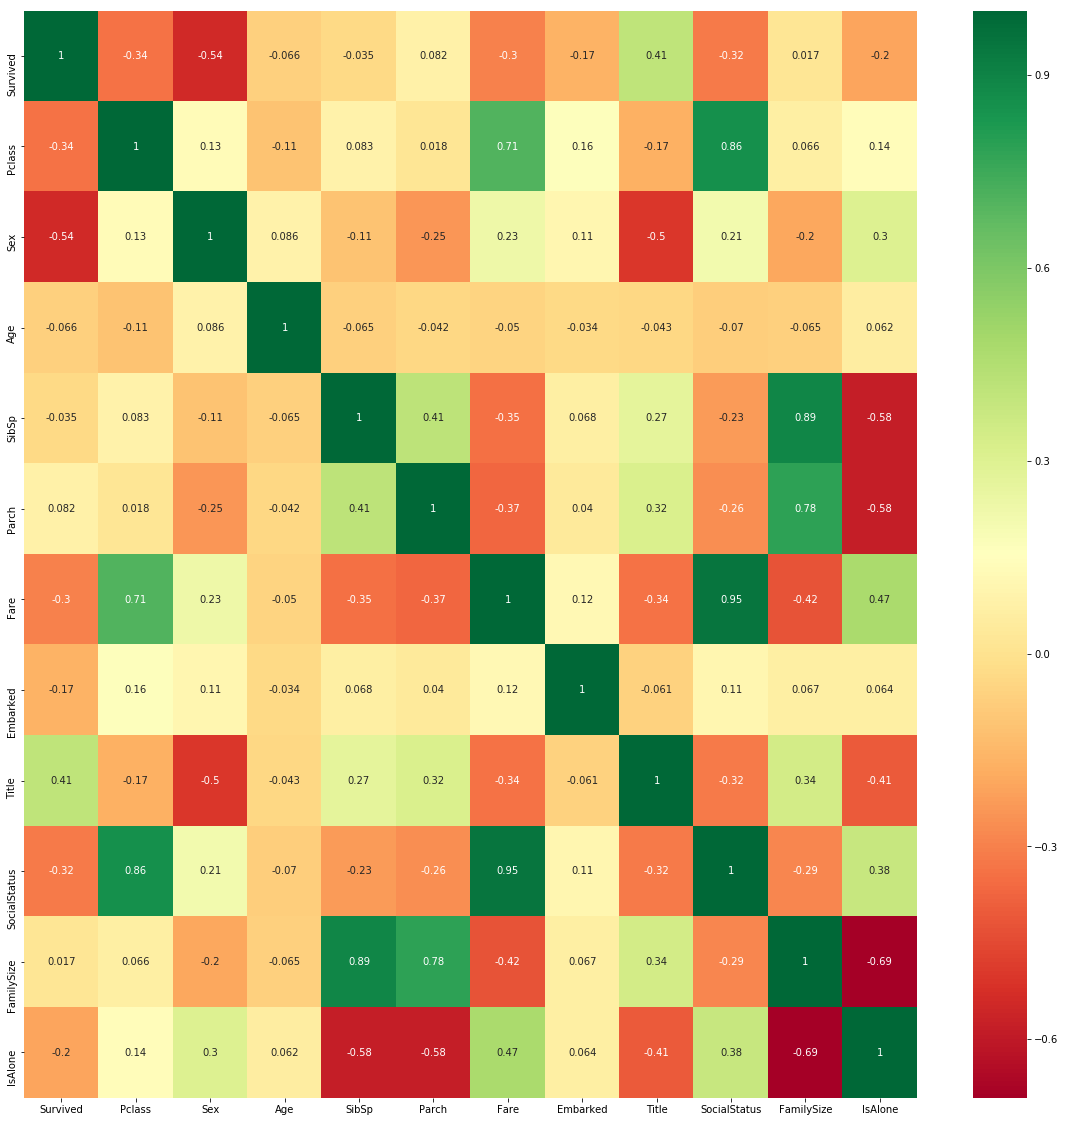

In [34]:
#get correlations of each features in dataset
corrmat = data_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [35]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,SocialStatus,FamilySize,IsAlone
0,3,1,2.0,0,0,3,1,1,9,1,1
1,3,0,2.0,1,0,3,2,3,9,2,0
2,2,1,3.0,0,0,2,1,1,4,1,1
3,3,1,1.0,0,0,2,2,1,6,1,1
4,3,0,1.0,1,1,2,2,3,6,3,0


In [36]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,SocialStatus,FamilySize,IsAlone
0,3,1,1.0,1,0,3,2,1,9,2,0
1,1,0,2.0,1,0,1,0,3,1,2,0
2,3,0,1.0,0,0,3,2,2,9,1,1
3,1,0,2.0,1,0,1,2,3,1,2,0
4,3,1,2.0,0,0,3,2,1,9,1,1


In [37]:
print(X_train.shape)
print(Y_train.tail)

(891, 11)
<bound method NDFrame.tail of 0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64>


In [38]:
# Choose the type of classifier. 
rf = RandomForestClassifier()

# Choose some parameter combinations to try
rf_parameters = {'n_estimators': [16, 18, 20, 22, 24, 26], 
              'max_features': ['sqrt'], 
              'criterion': ['entropy'],
              'max_depth': [5, 6], 
              'min_samples_split': [4, 5, 6],
              'min_samples_leaf': [6, 7, 8],
              'random_state': [0]
             }
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj_rf = GridSearchCV(rf, rf_parameters, scoring=acc_scorer, cv = 3, verbose=2, n_jobs=-1)
grid_obj_rf = grid_obj_rf.fit(X_train, Y_train)

# Set the clf to the best combination of parameters
best_rf = grid_obj_rf.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    9.7s finished


In [39]:
model = best_rf
best_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=24,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [40]:
#no of features
nof_list=np.arange(1,12)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train_aux, X_val, y_train_aux, y_val = train_test_split(X_train,Y_train, test_size = 0.3, random_state = 0)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_aux,y_train_aux)
    X_val_rfe = rfe.transform(X_val)
    model.fit(X_train_rfe,y_train_aux)
    score = model.score(X_val_rfe,y_val)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 10
Score with 10 features: 0.813433


In [41]:
cols = list(X_train.columns)
model = RandomForestClassifier()
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,Y_train) 
X_test = rfe.transform(X_test)
#Fitting the data to model
model.fit(X_rfe,Y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title',
       'SocialStatus', 'FamilySize'],
      dtype='object')


In [42]:
xgb1 = XGBClassifier()

xgb_parameters = {'learning_rate': [0.15, 0.25 ] ,
                  'n_estimators': [500],
                  'max_depth': [10],
                  'min_child_weight': [ 7 ],
                  'gamma': [ 0.0, 0.1, 0.4 ],
                  'colsample_bytree': [ 0.5],
                }

In [43]:
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

print(xgb_parameters)
# Run the grid search
grid_obj_xgb = GridSearchCV(xgb1, xgb_parameters, scoring=acc_scorer, cv = 3, verbose=2, n_jobs=-1)
grid_obj_xgb = grid_obj_xgb.fit(X_train, Y_train)

# Set the clf to the best combination of parameters
best_xgb = grid_obj_xgb.best_estimator_

{'learning_rate': [0.15, 0.25], 'n_estimators': [500], 'max_depth': [10], 'min_child_weight': [7], 'gamma': [0.0, 0.1, 0.4], 'colsample_bytree': [0.5]}
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    6.9s finished


In [44]:
best_rf.fit(X_rfe, Y_train)
Y_pred = best_rf.predict(X_test)

In [45]:
#best RF
submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': Y_pred})
submission.to_csv('submissionbestRF.csv',index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
